# Closing bracket all prediction performance
In this notebook, we focus on the "closing bracket" domain knowledge structure. We study the whole prediction perfomance and how the prerequisite links existing between KCs influence it. Contrary to the transition prediction performance, which is the capacity of our model to predict the success of a learner on an exercise when he has done an exercise on another KC right before, we study here every learner interaction traces. 

In [1]:
import sys
sys.path.append("/Users/olivier/PycharmProjects/bayesian-kst/")  # for mac

import pyAgrum as gum
from kgraph.expert_layer.domain import Domain
from kgraph.expert_layer.knowledge_components import KnowledgeComponent
from kgraph.expert_layer.link import Link
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import LearnerTrace
from kgraph.learner_layer.learner import Learner
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.helpers.truthtable import truthtable
from math import floor
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import random
import itertools
import numpy as np
import tqdm
import sklearn.metrics as sk_metrics
from sklearn.model_selection import KFold
import pandas as pd

In [2]:
def setup_domain_and_resources_from_dataset(dataset):
    assert any((isinstance(dataset, str), isinstance(dataset, pd.DataFrame))), "dataset must be str or dataframe" 
    df = dataset if isinstance(dataset, pd.DataFrame) else pd.read_csv(dataset)
    knowledge_components, exercises = [], []
    for i, row in df.iterrows():
        kc_id = row["kd_id"]
        if kc_id not in [kc.id for kc in knowledge_components]:
            kc_name = row['kd_name'] if 'kd_name' in df.columns else kc_id
            kc = KnowledgeComponent(kc_id, kc_name)
            knowledge_components.append(kc)
        else:
            kc = [kc for kc in knowledge_components if kc.id == kc_id][0]
        exercise_id = row['kae_id']
        if exercise_id not in [exercise.id for exercise in exercises]:
            exercise = Exercise(row['kae_id'], kc)
            exercises.append(exercise)
    domain = Domain(knowledge_components)
    return domain, exercises

def deduce_learner_traces_from_dataset(dataset, domain, exercises, learner_pool):
    """
    The traces are sorted by learner id
    """
    assert any((isinstance(dataset, str), isinstance(dataset, pd.DataFrame))), "dataset must be str or dataframe" 
    df = dataset if isinstance(dataset, pd.DataFrame) else pd.read_csv(dataset)

    learners = [Learner(learner_id, learner_pool) for learner_id in np.unique(dataset['user_id'])]
    learner_traces = {}
    for learner in learners:
        learner_df = df[df['user_id'] == learner.id]
        learner_traces[learner] = []
        for i, row in learner_df.iterrows(): 
            exercise = next((x for x in exercises if x.id == row['kae_id']), None)
            if exercise is None: 
                return Exception('exercise is none')
            success = bool(row['uea_success'])
            trace = LearnerTrace(learner, exercise, success)
            learner_traces[learner].append(trace)
    return learner_traces
    
def process_dataset(dataset, domain, exercises, learner_pool, model_type, c={}, s={}):
    assert any((isinstance(dataset, str), isinstance(dataset, pd.DataFrame))), "dataset must be str or dataframe" 
    df = dataset if isinstance(dataset, pd.DataFrame) else pd.read_csv(dataset)

    learner_traces = deduce_learner_traces_from_dataset(dataset, domain, exercises, learner_pool)

    exp_vals = []
    pred_vals = []
    
    for learner in learner_traces.keys():
        exp_vals = np.concatenate((exp_vals, [trace.get_success() for trace in learner_traces[learner]]))
        pred_vals = np.concatenate((pred_vals, learner.predict_sequence(learner_traces[learner], model_type, {'c': c, 's': s})))

    return exp_vals, pred_vals


## Import the data

In [3]:
df = pd.read_csv("quadratic_equations_cleaned.csv")

In [4]:
max_ids = df.groupby(['kd_id'], sort=False).count().sort_values(by='uea_success', ascending=False)
max_ids.head(10)

,Unnamed: 0,uea_id,uea_answer,uea_success,kae_id,uea_created_at,uea_updated_at,uaa_id,uaa_status,user_id,...,chapter_contains_documents,chapter_display_order,chapter_displayed_on_front,lhc_id,course_id,level_id,teaching_id,lhc_displayed_on_front,schoolyear_id,exercise_duration
kd_id,,,,,,,,,,,,,,,,,,,,,
3828,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,...,2832,2832,2832,2832,2832,2832,2832,2832,2832,2831
52084,2608,2608,2608,2608,2608,2608,2608,2608,2608,2608,...,2608,2608,2608,2608,2608,2608,2608,2608,2608,2608
52089,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,...,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197
52091,2133,2133,2133,2133,2133,2133,2133,2133,2133,2133,...,2133,2133,2133,2133,2133,2133,2133,2133,2133,2133
52090,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,...,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041
53667,1986,1986,1986,1986,1986,1986,1986,1986,1986,1986,...,1986,1986,1986,1986,1986,1986,1986,1986,1986,1986
52086,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,...,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964
52092,1850,1850,1850,1850,1850,1850,1850,1850,1850,1850,...,1850,1850,1850,1850,1850,1850,1850,1850,1850,1849
52085,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557,...,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557


In [5]:
sub_df = df[df["kd_id"].isin([52086, 53668])] #, 57428, 57421, 57451])]
selected_ids = sub_df.groupby(['kd_id'], sort=False).count()
selected_ids.head(10)

,Unnamed: 0,uea_id,uea_answer,uea_success,kae_id,uea_created_at,uea_updated_at,uaa_id,uaa_status,user_id,...,chapter_contains_documents,chapter_display_order,chapter_displayed_on_front,lhc_id,course_id,level_id,teaching_id,lhc_displayed_on_front,schoolyear_id,exercise_duration
kd_id,,,,,,,,,,,,,,,,,,,,,
52086,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,...,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964
53668,508,508,508,508,508,508,508,508,508,508,...,508,508,508,508,508,508,508,508,508,507


In [6]:
print(len(sub_df.index))

2472


In [7]:
from pyBKT.models import Model
import pandas as pd

def get_strongest_folds(full, axis="user_id", nb_folds=5):
    all_elements = full[axis].unique()

    kfold = KFold(nb_folds, shuffle=True)
    folds = []
    for i, (train, test) in enumerate(kfold.split(all_elements)):
        list_of_test_ids = []
        for element_id in test:
            list_of_test_ids += list(full.query(f'{axis} == {all_elements[element_id]}').index)
        folds.append(np.array(list_of_test_ids))
    
    return folds

folds = get_strongest_folds(sub_df, "user_id", 2)
test_ids = folds[0]

train_ids = list(set(list(sub_df.index.values)) - set(test_ids))

df_train = sub_df[sub_df.index.isin(train_ids)]
df_test = sub_df[sub_df.index.isin(test_ids)]


# Initialize the model with an optional seed
model = Model(seed = 42, num_fits = 1)
defaults = {'order_id': 'uea_id',
            'skill_name': 'kd_id',
            'correct': 'uea_success',
            'user_id': 'user_id',
            'multilearn': 'kd_id',
            'multiprior': 'uea_success',
            'multipair': 'kd_id',
            'multigs': 'kae_id',
            'folds': 'user_id'
           }

print(np.unique(df_train['kd_id']))
print(np.unique(df_test['kd_id']))
model.fit(data = df_train, defaults = defaults,multigs = True, forgets = False, multilearn = True)


df_test = df_test

preds_df = model.predict(data=df_test)

all_exp = df_test["uea_success"]
all_pred = list(preds_df["correct_predictions"])
print(all_pred)

[52086 53668]
[52086 53668]
[0.8386776778574326, 0.9634738142222874, 0.8583088358952129, 0.8386776778574326, 0.9634738142222874, 0.8583088358952129, 0.9945494192277994, 0.9015960446485751, 0.8386776778574326, 0.9634738142222874, 0.8583088358952129, 0.9945494192277994, 0.9015960446485751, 0.8386776778574326, 0.9634738142222874, 0.8583088358952129, 0.9945494192277994, 0.9015960446485751, 0.8386776778574326, 0.9634738142222874, 0.8583088358952129, 0.9945494192277994, 0.9015960446485751, 0.6905896456919136, 0.5466244609217756, 0.6397370801010057, 0.7866809040605006, 0.7487187663314143, 0.7444320128286714, 0.49595880960614624, 0.7794556298639105, 0.896687351807594, 0.718249477478312, 0.8386776778574326, 0.9634738142222874, 0.8047233419670831, 0.9086284085668475, 0.9401141108955134, 0.8909489808620406, 0.9826846425699403, 0.8615203526671688, 0.6905896456919136, 0.7858680310639724, 0.8775041578339834, 0.6626680302247151, 0.8333845147964241, 0.8064023449721859, 0.9509821870048423, 0.8508671515

In [8]:
df_test.head()


,Unnamed: 0,uea_id,uea_answer,uea_success,kae_id,uea_created_at,uea_updated_at,uaa_id,uaa_status,user_id,...,chapter_displayed_on_front,lhc_id,course_id,level_id,teaching_id,lhc_displayed_on_front,schoolyear_id,exercise_duration,correct_predictions,state_predictions
13271,64151,138280802,"{""3012654"":true,""3012655"":false,""3012656"":fals...",1,227564,2020-11-13 19:24:25,2020-11-13 19:24:25,95426561,1.00000,104381,...,1,1186,1,15,5,1,166,0 days 00:00:21,0.83868,0.83004
13272,64152,138280819,"{""3025316"":true,""3025317"":false,""3025318"":fals...",1,227565,2020-11-13 19:24:46,2020-11-13 19:24:46,95426561,1.00000,104381,...,1,1186,1,15,5,1,166,0 days 00:05:04,0.96347,0.98365
13273,64153,138281118,"{""3025328"":false,""3025329"":false,""3025330"":fal...",0,227566,2020-11-13 19:29:50,2020-11-13 19:29:50,95426561,1.00000,104381,...,1,1186,1,15,5,1,166,0 days 00:00:00,0.85831,0.99255
12558,63227,135218252,"{""3012654"":true,""3012655"":false,""3012656"":fals...",1,227564,2020-09-21 20:02:40,2020-09-21 20:02:40,94631502,2.00000,134163,...,1,1186,1,15,5,1,166,0 days 00:00:29,0.83868,0.83004
12559,63228,135218282,"{""3025316"":true,""3025317"":false,""3025318"":fals...",1,227565,2020-09-21 20:03:09,2020-09-21 20:03:09,94631502,2.00000,134163,...,1,1186,1,15,5,1,166,0 days 00:01:37,0.96347,0.98365


In [9]:
acc = sk_metrics.accuracy_score(all_exp, [1 if all_pred[i]>.5 else 0 for i in range(len(all_pred))])
auc = sk_metrics.roc_auc_score(all_exp, all_pred)
cohen_kappa = max([
    sk_metrics.cohen_kappa_score(
        np.array(all_exp), 
        [1 if all_pred[i]>j else 0 for i in range(len(all_pred))]) for j in np.linspace(0, 1, 100)]
)

print(acc, auc, cohen_kappa)


0.8544600938967136 0.720807210031348 0.22453073326966622


## Score of the transition prediction performance

### No linking -- should be equivalent to BKT

In [10]:
def set_learning_pool_parameters_from_bkt_parameters(learner_pool, bkt_params):
    for kc in learner_pool.get_knowledge_components():
        learner_pool.set_prior(kc, model.params().loc[f'{kc.id}', 'prior', 'default'].value)
        
        learner_pool.set_learn(kc, model.params().loc[f'{kc.id}', 'learns', f'{kc.id}'].value)
        learner_pool.set_forget(kc, model.params().loc[f'{kc.id}', 'forgets', f'{kc.id}'].value)
        
        for exercise in kc.get_exercises():
            learner_pool.set_guess(exercise, model.params().loc[f'{kc.id}', 'guesses', f'{exercise.id}'].value)
            learner_pool.set_slip(exercise, model.params().loc[f'{kc.id}', 'slips', f'{exercise.id}'].value)
    return learner_pool

In [11]:
domain, exercises = setup_domain_and_resources_from_dataset(df_test)
print(domain)

Domain on 2 KCs:
- KC 52086: Calculer le discriminant d'un polynôme du second degré donné sous forme développée
- KC 53668: Résoudre une équation du second degré



In [12]:
params = model.params()
learner_pool = LearnerPool(domain, {})
learner_pool = set_learning_pool_parameters_from_bkt_parameters(learner_pool, params)

metrics = ['accuracy', 'roc_auc', 'cohen_kappa']

all_exp, all_pred = process_dataset(df_test, domain, exercises, learner_pool, 'NoisyAND')


print(all_pred)


acc = sk_metrics.accuracy_score(all_exp, [1 if all_pred[i]>.5 else 0 for i in range(len(all_pred))])
auc = sk_metrics.roc_auc_score(all_exp, all_pred)
cohen_kappa = max([
    sk_metrics.cohen_kappa_score(np.array(all_exp), [1 if all_pred[i]>j else 0 for i in range(len(all_pred))])
    for j in np.linspace(0, 1, 100)
])

print(acc, auc, cohen_kappa)



[0.83867768 0.96347381 0.85830884 ... 0.98575893 0.78382352 0.84932087]
0.8544600938967136 0.720807210031348 0.22453073326966622


In [13]:
params = model.params()
print(params)
learner_pool = LearnerPool(domain, {})
learner_pool = set_learning_pool_parameters_from_bkt_parameters(learner_pool, params)

metrics = ['accuracy', 'roc_auc', 'cohen_kappa']

all_exp, all_pred = process_dataset(df_test, domain, exercises, learner_pool, 'NoisyOR')

acc = sk_metrics.accuracy_score(all_exp, [1 if all_pred[i]>.5 else 0 for i in range(len(all_pred))])
auc = sk_metrics.roc_auc_score(all_exp, all_pred)
cohen_kappa = max([
    sk_metrics.cohen_kappa_score(np.array(all_exp), [1 if all_pred[i]>j else 0 for i in range(len(all_pred))])
    for j in np.linspace(0, 1, 100)
])

print(acc, auc, cohen_kappa)

                        value
skill param   class          
52086 prior   default 0.83004
      learns  52086   0.28352
      guesses 227564  0.11262
              227565  0.61227
              227566  0.40340
              227567  0.31198
              227568  0.33997
      slips   227564  0.01265
              227565  0.03069
              227566  0.13828
              227567  0.00374
              227568  0.09809
      forgets 52086   0.00000
53668 prior   default 0.73755
      learns  53668   0.23668
      guesses 236577  0.56615
              236578  0.08025
              236579  0.16910
              236580  0.20852
              236581  0.31377
      slips   236577  0.19213
              236578  0.08049
              236579  0.33560
              236580  0.16619
              236581  0.17533
      forgets 53668   0.00000
0.8544600938967136 0.720807210031348 0.22453073326966622


0.8578703703703704 0.6691228845389069 0.1472657973921766

In [14]:
print([kc.name for kc in domain.get_knowledge_components()])
link_strength = {
    domain.get_kc_by_name("Résoudre une équation du second degré"): {
        domain.get_kc_by_name("Calculer le discriminant d'un polynôme du second degré donné sous forme développée"): 'strong'
    }
                 }

learner_pool = LearnerPool(domain, link_strength)
learner_pool = set_learning_pool_parameters_from_bkt_parameters(learner_pool, params)


import copy

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

learner_traces = deduce_learner_traces_from_dataset(df_test, domain, exercises, learner_pool)

result_and = learner_pool.get_optimized_parameters(learner_traces, 'NoisyAND')

result_or = learner_pool.get_optimized_parameters(learner_traces, 'NoisyOR')



["Calculer le discriminant d'un polynôme du second degré donné sous forme développée", 'Résoudre une équation du second degré']
c:  0.5
s:  0.0
0.7038287823791454 0.18888166698528008
c:  0.5
s:  0.1
0.7035529409338392 0.18888166698528008
c:  0.5
s:  0.2
0.7033260806797558 0.18888166698528008
c:  0.5
s:  0.30000000000000004
0.7032874113182643 0.18888166698528008
c:  0.5
s:  0.4
0.7031507795743277 0.18888166698528008
c:  0.6
s:  0.0
0.7060896510476818 0.19156995517219255
c:  0.6
s:  0.1
0.7059040381125227 0.18957763334675604
c:  0.6
s:  0.2
0.7057596724962878 0.18873287476550515
c:  0.6
s:  0.30000000000000004
0.7056307746246494 0.18873287476550515
c:  0.6
s:  0.4
0.7055199224550404 0.18873287476550515
c:  0.7
s:  0.0
0.7085361326513777 0.19312852830218008
c:  0.7
s:  0.1
0.7084562159709618 0.1917855522407237
c:  0.7
s:  0.2
0.7081004578452401 0.1917855522407237
c:  0.7
s:  0.30000000000000004
0.7080282750371225 0.18957763334675604
c:  0.7
s:  0.4
0.7075977561458505 0.18770968598392512
c

In [17]:
cohen_vals = []
for c_value in tqdm.tqdm(np.linspace(.5, 1, 5)):
    temp = []
    for s_value in np.linspace(0, .5, 5):
        c = {domain.get_kc_by_name("Calculer le discriminant d'un polynôme du second degré donné sous forme développée"): {
            domain.get_kc_by_name(
                "Résoudre une équation du second degré"): c_value
            }
        }
        s = {domain.get_kc_by_name("Calculer le discriminant d'un polynôme du second degré donné sous forme développée"): {
            domain.get_kc_by_name(
                "Résoudre une équation du second degré"): s_value
            }
        }

        all_exp, all_pred = process_dataset(df_test, domain, exercises, learner_pool, 'NoisyAND', c, s)
        
        cohen_kappa = max([
            sk_metrics.cohen_kappa_score(np.array(all_exp), [1 if all_pred[i]>j else 0 for i in range(len(all_pred))])
            for j in np.linspace(0, 1, 100)
        ])
        temp.append(cohen_kappa)
    cohen_vals.append(temp)

100%|██████████| 5/5 [05:05<00:00, 61.07s/it]


In [ ]:
print(cohen_vals)

[[0.5   0.625 0.75  0.875 1.   ]
 [0.5   0.625 0.75  0.875 1.   ]
 [0.5   0.625 0.75  0.875 1.   ]
 [0.5   0.625 0.75  0.875 1.   ]
 [0.5   0.625 0.75  0.875 1.   ]] [[0.    0.    0.    0.    0.   ]
 [0.125 0.125 0.125 0.125 0.125]
 [0.25  0.25  0.25  0.25  0.25 ]
 [0.375 0.375 0.375 0.375 0.375]
 [0.5   0.5   0.5   0.5   0.5  ]]


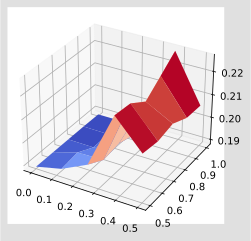

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.linspace(.5, 1, 5)
Y = np.linspace(0, .5, 5)
X, Y = np.meshgrid(X, Y)
print(X, Y)
Z = np.array(cohen_vals)

# Plot the surface.
surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [20]:
print(np.array(cohen_vals))

[[0.18888167 0.18888167 0.18888167 0.18888167 0.18873287]
 [0.19156996 0.19257135 0.18873287 0.18873287 0.18873287]
 [0.19705561 0.19285076 0.19391995 0.19178555 0.18983284]
 [0.22121961 0.22042733 0.21559473 0.22097492 0.22645316]
 [0.20897015 0.20797665 0.20948772 0.20621118 0.20586436]]
